In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ReLU Deep Dive + Keras Model

In this notebook, we will dive deeper in to how ReLU works as well as build a simple regression model in Keras to compare how ReLU influences the outputs vs Tanh.

At the end, we will also show how softmax works and how you can define categorical-crossentropy from scratch

We first define the "true function," which is the mathematical function we are trying to approximate with the neural networks given noisy data.

It would make the modeling task far too easy if the y data was the pure, unaltered output of the true function, so adding some noise forces the network to create its best approximation. 

In [4]:
true_fn = lambda x: 0.9*x**3 - 0.5*x**2 + 0.07*x 


Here, we create the noisy y data (to be used in training) as well as the true y data (to be used in testing)

In [5]:
x = np.linspace(-1, 1, num=10000)
noise = np.random.normal(loc=0, scale=0.03, size=len(x))
y_true = true_fn(x)
y = y_true + noise

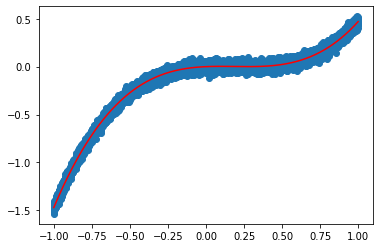

In [6]:
plt.scatter(x, y)
plt.plot(x, y_true, c='red')


We are randomly splitting up the dataset's index into train and test splits so that we can use these to select the training y samples and the corresponding testing y samples.

In [7]:
indices = range(len(y))
train_len = int(0.8 * len(y))
train_indices = np.random.choice(indices, size=train_len, replace=False)
test_indices = list(set(indices).difference(set(train_indices)))
x_train = x[train_indices]
x_test = x[test_indices]

y_train = y[train_indices]
y_test = y[test_indices]


In [8]:
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

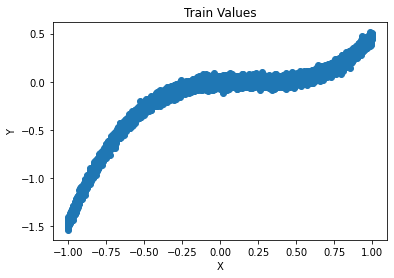

In [9]:
plt.title("Train Values")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(x_train, y_train)

We will manually be computing the forward pass to demonstrate how ReLU works layer-by-layer.

The weights are specifically chosen to show how we can composite the previous layer's ReLU outputs into a new ReLU function.

In [10]:
# Manually Computed Forward Pass 
w1 = np.array([[-0.1, 0.9, 0.3]])
b1 = np.array([0.1, 0.1, -0.05])


In [11]:
# Z is the raw layer output
z1 = x_train @ w1 + b1
# A is the post-activation output
a1 = np.maximum(0, z1)

We will be plotting the pre-ReLU outputs in a light color to demonstrate what the original outputs were. The post-ReLU outputs are in darker colors to show how ReLU clips the original negatiive values to zero.

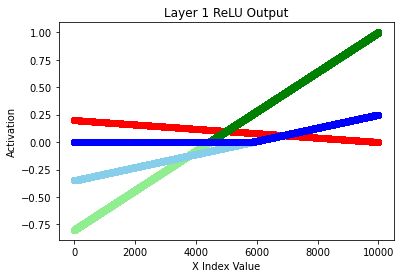

In [12]:
plt.title("Layer 1 ReLU Output")
plt.xlabel("X Index Value")
plt.ylabel("Activation")

plt.scatter(train_indices, z1[:, 0], c='pink')
plt.scatter(train_indices, z1[:, 1], c='lightgreen')
plt.scatter(train_indices, z1[:, 2], c='skyblue')

plt.scatter(train_indices, a1[:, 0], c='red')
plt.scatter(train_indices, a1[:, 1], c='green')
plt.scatter(train_indices, a1[:, 2], c='blue')

We want three ReLU outputs, and there are three ReLU inputs, so the weight matrix ends up being 3x3.

The first row of the weight matrix computes a weighted combination of the three inputs (in column order, red, green, and blue) to form layer 2's red output.

The second row is for the new green output, and the third row is for the new blue output.

Interpret the first row as saying:
"The new red output is 2.3 times original_red + -0.9 times original_green + 1.2 times original_blue"

Of course, this is all the pre-activation output. Once ReLU is applied, any values below zero are clipped to zero.

In [13]:
w2 = np.array([[2.3, -0.9, 1.2 ],
               [-0.9, 0.92, -0.2 ], 
               [5.3, -0.2, 0.1 ]])
b2 = np.array([-0.1, -0.1, 0.1])

In [14]:
z2 = a1 @ w2 + b2
a2 = np.maximum(0, z2)

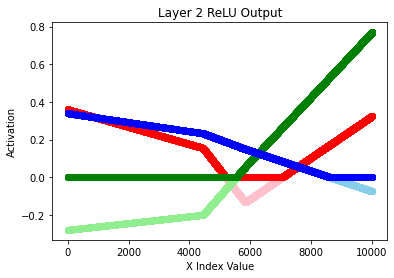

In [15]:
plt.title("Layer 2 ReLU Output")
plt.xlabel("X Index Value")
plt.ylabel("Activation")

plt.scatter(train_indices, z2[:, 0], c='pink')
plt.scatter(train_indices, z2[:, 1], c='lightgreen')
plt.scatter(train_indices, z2[:, 2], c='skyblue')

plt.scatter(train_indices, a2[:, 0], c='red')
plt.scatter(train_indices, a2[:, 1], c='green')
plt.scatter(train_indices, a2[:, 2], c='blue')

In [16]:
w3 = np.array([[1.0, 0.9, -1.1 ],
               [1.1, 0.92, 0.5 ],
               [-0.1, -0.9, -0.1 ]])
b3 = np.array([0.2, -0.4, 0.1])

z3 = a2 @ w3 + b3
a3 = np.maximum(0, z3)

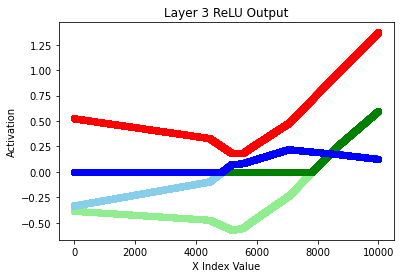

In [17]:
plt.title("Layer 3 ReLU Output")
plt.xlabel("X Index Value")
plt.ylabel("Activation")

plt.scatter(train_indices, z3[:, 0], c='pink')
plt.scatter(train_indices, z3[:, 1], c='lightgreen')
plt.scatter(train_indices, z3[:, 2], c='skyblue')

plt.scatter(train_indices, a3[:, 0], c='red')
plt.scatter(train_indices, a3[:, 1], c='green')
plt.scatter(train_indices, a3[:, 2], c='blue')

We only have one output now, so we want to condense the input size of 3 to an output size of 1.

We are now saying that the final, raw output is 1.0 times the previous red ReLU output - 0.9 times the previous green ReLU output + 0.1 times the previous blue ReLU output.


In [18]:
w4 = np.array([[1.0],
               [-0.9],
               [0.1]])
b4 = np.array([0.1])

z4 = a3 @ w4 + b4


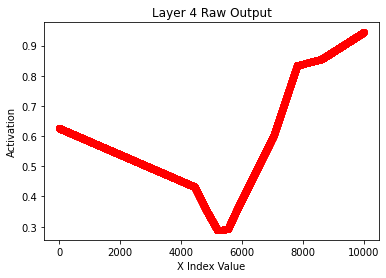

In [19]:
plt.title("Layer 4 Raw Output")
plt.xlabel("X Index Value")
plt.ylabel("Activation")

plt.scatter(train_indices, z4[:, 0], c='red')

We will now use Keras on our toy dataset from earlier to model this function using tanh and another one using relu to compare how their respective approximations of the true function look.

In [20]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

from sklearn.metrics import mean_squared_error

In [21]:
# model

inp = Input(shape=(x_train.shape[-1], ))
l1 = Dense(3, activation='tanh')(inp)
l2 = Dense(3, activation='tanh')(l1)
l3 = Dense(3, activation='tanh')(l2)
l4 = Dense(3, activation='tanh')(l3)
out = Dense(1, activation=None)(l4)

m = Model(inp, out)
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 3)                 6         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 3)                 12        
                                                                 
 dense_3 (Dense)             (None, 3)                 12        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 46
Trainable params: 46
Non-trainable params: 0

In [22]:
m.compile(optimizer='adam', loss='mean_squared_error')

In [1210]:
epochs = 50

m.fit(x_train, y_train, batch_size=128, epochs=epochs)

Epoch 1/50
63/63 [==============================] - 1s 5ms/step - loss: 0.2486
Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 0.1896
Epoch 3/50
63/63 [==============================] - 0s 3ms/step - loss: 0.1373
Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0762
Epoch 5/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0481
Epoch 6/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0351
Epoch 7/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0263
Epoch 8/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0201
Epoch 9/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 10/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 11/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 12/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 13/50
63/63 [==============================

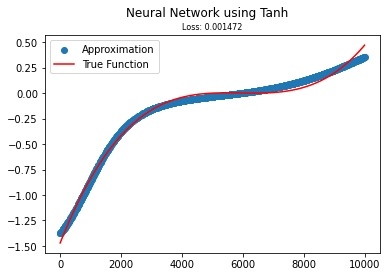

In [1221]:
preds = m.predict(x_test)
loss = mean_squared_error(true_fn(x_test), preds)

plt.suptitle("Neural Network using Tanh")
plt.title(f"Loss: {loss:.6f}", fontsize=8)
plt.scatter(test_indices, preds, label='Approximation')
plt.plot(y_true, c='red', label='True Function')
plt.legend()

Notice how smooth and rounded this curve looks when we use Tanh as the activation functions.

We will now repeat this but with ReLU.

In [1214]:
# model

inp = Input(shape=(x_train.shape[-1], ))
l1 = Dense(3, activation='relu')(inp)
l2 = Dense(3, activation='relu')(l1)
l3 = Dense(3, activation='relu')(l2)
l4 = Dense(3, activation='relu')(l3)
out = Dense(1, activation=None)(l4)

m2 = Model(inp, out)
m2.summary()

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_222 (Dense)           (None, 3)                 6         
                                                                 
 dense_223 (Dense)           (None, 3)                 12        
                                                                 
 dense_224 (Dense)           (None, 3)                 12        
                                                                 
 dense_225 (Dense)           (None, 3)                 12        
                                                                 
 dense_226 (Dense)           (None, 1)                 4         
                                                                 
Total params: 46
Trainable params: 46
Non-trainable params

In [1215]:
m2.compile(optimizer='adam', loss='mean_squared_error')

In [1216]:
epochs = 50

m2.fit(x_train, y_train, batch_size=128, epochs=epochs)

Epoch 1/50
63/63 [==============================] - 1s 5ms/step - loss: 0.1752
Epoch 2/50
63/63 [==============================] - 0s 4ms/step - loss: 0.1519
Epoch 3/50
63/63 [==============================] - 0s 4ms/step - loss: 0.1356
Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: 0.1208
Epoch 5/50
63/63 [==============================] - 0s 3ms/step - loss: 0.1072
Epoch 6/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0945
Epoch 7/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0823
Epoch 8/50
63/63 [==============================] - 0s 4ms/step - loss: 0.0720
Epoch 9/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 10/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0557
Epoch 11/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0492
Epoch 12/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0435
Epoch 13/50
63/63 [==============================

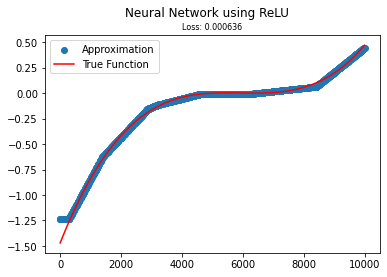

In [1222]:
preds = m2.predict(x_test)
loss = mean_squared_error(true_fn(x_test), preds)

plt.suptitle("Neural Network using ReLU")
plt.title(f"Loss: {loss:.6f}", fontsize=8)
plt.scatter(test_indices, preds, label='Approximation')
plt.plot(y_true, c='red', label='True Function')
plt.legend()

Notice how the function is approximated using linear snippets put together. It's a computationally efficient way to approximate complex functions.

We will also demonstrate how softmax works

### Softmax

In [23]:
softmax = lambda z: np.exp(z) / np.exp(z).sum()

z = np.array([-1.2, 2.5, 0.1])

scores = softmax(z)

pred = np.argmax(scores)
print('Raw Output (logits):', z)
print('Probability Scores:', scores)
print('Prediction: ', pred)

Raw Output (logits): [-1.2  2.5  0.1]
Probability Scores: [0.02216479 0.89650602 0.08132919]
Prediction:  1


In [27]:
z = np.array([[-1.2, 2.5, 0.1],
             [-2.2, 4.5, 2.1],
             [1.2, -2.5, 0.1],
             [1.2, 7.5, -0.1],
             [-1.2, -2.2, 0.1]])

y = np.array([[1, 0, 0],
             [0, 0, 1],
             [0, 1, 0],
             [0, 0, 1],
             [0, 1, 0]])

# Instead of one-hot class representation, just have the numerical class label
yy = y.argmax(axis=1)

scores = softmax(z)
scores

array([[1.56045038e-04, 6.31160116e-03, 5.72575539e-04],
       [5.74057615e-05, 4.66367750e-02, 4.23079278e-03],
       [1.72011198e-03, 4.25272341e-05, 5.72575539e-04],
       [1.72011198e-03, 9.36724666e-01, 4.68785202e-04],
       [1.56045038e-04, 5.74057615e-05, 5.72575539e-04]])

### Categorical CrossEntropy

Here, we implement categorical crossentropy loss from scratch.

The first method assumes that your y-data is in a one-hot encoded format.

In [28]:
loss = 0
for f in range(len(y)):
    tmp = 0
    for c in range(len(y[f])):
        tmp += y[f][c] * np.log(softmax(z[f])[c])
    loss += tmp
loss = -loss / (f+1)
print("Loss: ", loss)




Loss:  4.104421689247221


This method assumes your y-data is not one-hot encoded and instead has the direct numeric labels like 1, 4, 9, etc.

In [29]:
loss = 0
for f in range(len(yy)):
    tmp = np.log(softmax(z[f])[yy[f]])
    loss += tmp
loss = -loss / (f+1)
print("Loss: ", loss)




Loss:  4.104421689247221
